# Satisfaction

In [1]:
import pandas as pd
import sqlite3

from helpers.make_latex_table import create_latex_tables
from helpers.statistical_tests import run_t_test_on_gender

conn = sqlite3.connect("../../giicg.db")
users = pd.read_sql("Select c.*, u.gender from conversations c JOIN users u on c.user_id == u.user_id", conn)
conn.close()
users = users[(users['gender'].isin(['Man (cisgender)', 'Woman (cisgender)']))]

In [2]:
satisfaction_map = {
    'very dissatisfied': 1,
    'mostly dissatisfied': 2,
    'neutral': 3,
    'somewhat satisfied': 4,
    'very satisfied': 5
}

complexity_map = {
    'very simple': 1,
    'relatively simple': 2,
    'neither complex nor simple': 3,
    'relatively complex': 4,
    'very complex': 5
}

# Create a new column with coded values
users['satisfaction_code'] = users['satisfaction'].map(satisfaction_map)
users['complexity_code'] = users['rated_complexity'].map(complexity_map)

users

,conversation_id,user_id,mode,text,share_link,llm_version,satisfaction,explain_satisfaction,rated_complexity,gender,satisfaction_code,complexity_code
0,1,6,Share link,None,https://chatgpt.com/share/682b3298-bd58-8000-b...,None,neutral,None,neither complex nor simple,Man (cisgender),3,3
1,2,8,JSON/Text,I am working on the problem of reconstruction ...,None,ChatGPT-4o-mini-high,somewhat satisfied,None,relatively complex,Man (cisgender),4,4
2,3,11,Share link,None,https://chatgpt.com/share/682b387d-16ec-8010-8...,None,very satisfied,None,very simple,Woman (cisgender),5,1
3,4,14,Share link,None,https://chatgpt.com/share/682b48e3-94c0-8005-8...,None,somewhat satisfied,None,neither complex nor simple,Man (cisgender),4,3
4,5,15,JSON/Text,SET_ALL_TABLES action is currently not fetchin...,None,Claude 3.7 Sonnet,somewhat satisfied,None,relatively complex,Man (cisgender),4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,60,Share link,None,https://chatgpt.com/share/68358d62-9b20-800d-a...,ChatGPT-4o,very satisfied,None,very simple,Woman (cisgender),5,1
86,87,73,Share link,None,https://chatgpt.com/share/68385b69-0548-800c-9...,ChatGPT-4o,somewhat satisfied,None,neither complex nor simple,Woman (cisgender),4,3
87,88,77,Share link,None,https://chatgpt.com/share/683edda1-2be8-800d-9...,ChatGPT-4,somewhat satisfied,None,very simple,Man (cisgender),4,1
88,89,79,Share link,None,https://chatgpt.com/share/683eecd0-d638-800d-8...,gpt-40,somewhat satisfied,None,relatively complex,Woman (cisgender),4,4


In [3]:
users = users[users['user_id'] != 14]
users_per_gender = users.groupby('gender')['user_id'].nunique().reset_index(name='num_users')
users_per_gender

,gender,num_users
0,Man (cisgender),15
1,Woman (cisgender),13


## Satisfaction

In [4]:
user_satisfaction = users.groupby(['user_id', 'gender'])['satisfaction_code'].mean().reset_index()
user_satisfaction.rename(columns={'satisfaction_code': 'mean_satisfaction'}, inplace=True)
user_satisfaction

,user_id,gender,mean_satisfaction
0,6,Man (cisgender),3.666667
1,8,Man (cisgender),4.000000
2,11,Woman (cisgender),5.000000
3,15,Man (cisgender),4.000000
4,16,Woman (cisgender),4.500000
5,25,Man (cisgender),3.800000
6,28,Woman (cisgender),3.750000
7,29,Woman (cisgender),4.000000
8,31,Man (cisgender),3.333333
9,34,Man (cisgender),4.000000


In [5]:
gender_means = user_satisfaction.groupby(['gender']).mean().reset_index()
gender_means

,gender,user_id,mean_satisfaction
0,Man (cisgender),52.000000,4.012222
1,Woman (cisgender),54.307692,4.203846


In [5]:
from statsmodels.stats.multitest import multipletests
from helpers.statistical_tests import compare_genders


def groupwise_comparison_with_correction(df, columns, one_sided=False, direction="greater"):
    stat_vals = []
    dfs= []
    p_vals = []
    test_types = []
    directions = []
    one_sideds = []
    female_means = []
    male_means = []
    female_stds = []
    male_stds = []
    n_females = []
    n_males = []
    nonzero_females = []
    nonzero_males = []
    effsizes = []
    effsize_types = []
    cis = []
    for col in columns:
        result = compare_genders(df, col, one_sided=one_sided, direction=direction)
        stat_vals.append(result['test_statistic'])
        dfs.append(result['df'])
        p_vals.append(result['p_value'])
        test_types.append(result['test_type'])
        directions.append(result['direction'])
        one_sideds.append(result['one_sided'])
        female_means.append(result['m_female'])
        male_means.append(result['m_male'])
        female_stds.append(result['std_female'])
        male_stds.append(result['std_male'])
        n_females.append(result['n_female'])
        n_males.append(result['n_male'])
        nonzero_females.append(result['hits_female'])
        nonzero_males.append(result['hits_male']),
        effsizes.append(result['effect_size']),
        effsize_types.append(result['effect_size_type'])
        cis.append(result['effect_size_CI'])
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'direction': directions,
        'one_sided': one_sideds,
        'df': dfs,
        'stat_value': stat_vals,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'mean_f': female_means,
        'mean_m': male_means,
        'std_f': female_stds,
        'std_m': male_stds,
        'n_f': n_females,
        'n_m': n_males,
        'n_hits_f': nonzero_females,
        'n_hits_m': nonzero_males,
        'effsize': effsizes,
        'effsize_type': effsize_types,
        'ci': cis,
    })
    return results

In [6]:
satisfaction_results = groupwise_comparison_with_correction(user_satisfaction, ['mean_satisfaction'])
satisfaction_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,mean_satisfaction,T-test,two-sided,False,18.583763,-1.148441,0.265355,0.265355,4.203846,4.012222,0.530119,0.305535,13,15,13,15,-0.451699,Cohen's d,"[-1.39, 0.42]"


In [7]:
overall_mean = user_satisfaction['mean_satisfaction'].mean()
overall_mean

np.float64(4.101190476190476)

In [9]:
import scipy.stats as stats

# Suppose female and male are pandas Series of your group means
F = 0.2810 / 0.0871  # larger/smaller
df1 = 13 - 1
df2 = 16 - 1

# Two-tailed p-value
p_value = 2 * min(stats.f.cdf(F, df1, df2), 1 - stats.f.cdf(F, df1, df2))
print(f"F-statistic: {F:.4f}, p-value: {p_value:.4f}")


F-statistic: 3.2262, p-value: 0.0351


In [10]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "satisfaction_code ~ gender",         # fixed effect
    users,                               # prompt-level DataFrame
    groups=users["user_id"]              # random user intercept
)
result = model.fit()
print(result.summary())


                Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   satisfaction_code
No. Observations:   85        Method:               REML             
No. Groups:         28        Scale:                0.6701           
Min. group size:    1         Log-Likelihood:       -107.3839        
Max. group size:    5         Converged:            Yes              
Mean group size:    3.0                                              
---------------------------------------------------------------------
                            Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   3.982    0.144 27.648 0.000  3.700  4.264
gender[T.Woman (cisgender)] 0.196    0.200  0.980 0.327 -0.196  0.588
Group Var                   0.048    0.082                           



- **Per-user variance**: Small, but still larger than the (not significant) gender effect.
- **Gender effect**: Very minor and not reliable (the confidence interval includes zero).
- **Most variation** in satisfaction is **unexplained by either gender or user identity** (most variance is “residual”).


## Complexity

In [8]:
complexity = users.groupby(['user_id', 'gender'])['complexity_code'].mean().reset_index()
complexity.rename(columns={'complexity_code': 'mean_complexity'}, inplace=True)
complexity

,user_id,gender,mean_complexity
0,6,Man (cisgender),3.333333
1,8,Man (cisgender),4.000000
2,11,Woman (cisgender),1.000000
3,15,Man (cisgender),4.000000
4,16,Woman (cisgender),3.000000
5,25,Man (cisgender),2.600000
6,28,Woman (cisgender),2.750000
7,29,Woman (cisgender),3.000000
8,31,Man (cisgender),3.333333
9,34,Man (cisgender),2.500000


In [9]:
compl_gender_means = complexity.groupby(['gender']).mean().reset_index()
compl_gender_means

,gender,user_id,mean_complexity
0,Man (cisgender),52.000000,2.995556
1,Woman (cisgender),54.307692,2.496154


In [10]:
complexity_results = groupwise_comparison_with_correction(complexity, ['mean_complexity'])
complexity_results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,mean_complexity,T-test,two-sided,False,21.638285,1.379483,0.181837,0.181837,2.496154,2.995556,1.080598,0.78648,13,15,13,15,0.5348,Cohen's d,"[-0.23, 1.44]"


In [11]:
from helpers.make_latex_table import create_latex_tables
combined = pd.concat([satisfaction_results, complexity_results], axis=0)
create_latex_tables(combined, "latex/sat_compl_stats", "latex/sat_cmpl_hits")
combined

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
0,mean_satisfaction,T-test,two-sided,False,18.583763,-1.148441,0.265355,0.265355,4.203846,4.012222,0.530119,0.305535,13,15,13,15,-0.451699,Cohen's d,"[-1.39, 0.42]"
0,mean_complexity,T-test,two-sided,False,21.638285,1.379483,0.181837,0.181837,2.496154,2.995556,1.080598,0.786480,13,15,13,15,0.534800,Cohen's d,"[-0.23, 1.44]"


In [12]:
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
import seaborn as sns

gender_palette = {'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'}
age_palette = {'19-25': 'red', '26-30': 'orange', '31-35': 'yellow', '36-40': 'green', '41-50': 'blue', '51-60': 'purple'}


def box_plot(df, id_vars, bar_variables, x_label, y_label, hue_variable, palette):
    melted = df.melt(
    id_vars=id_vars,
    value_vars=bar_variables,
    var_name=x_label,
    value_name=y_label
)

    plt.figure(figsize=(8,6))
    sns.boxplot(
        data=melted,
        x=x_label,
        y=y_label,
        hue=hue_variable,
        palette=palette,
        width=0.7
    )

    plt.title(f'Counts and Scores by {hue_variable}')
    plt.ylabel('Average Count/Score Rate (per word)')
    plt.xlabel('Score/Count')
    plt.legend(title=hue_variable)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [16]:
combined_user_means = pd.concat([user_satisfaction, complexity], axis=1)
combined_user_means

,user_id,gender,mean_satisfaction,user_id,gender,mean_complexity
0,6,Man (cisgender),3.666667,6,Man (cisgender),3.333333
1,8,Man (cisgender),4.000000,8,Man (cisgender),4.000000
2,11,Woman (cisgender),5.000000,11,Woman (cisgender),1.000000
3,15,Man (cisgender),4.000000,15,Man (cisgender),4.000000
4,16,Woman (cisgender),4.500000,16,Woman (cisgender),3.000000
5,25,Man (cisgender),3.800000,25,Man (cisgender),2.600000
6,28,Woman (cisgender),3.750000,28,Woman (cisgender),2.750000
7,29,Woman (cisgender),4.000000,29,Woman (cisgender),3.000000
8,31,Man (cisgender),3.333333,31,Man (cisgender),3.333333
9,34,Man (cisgender),4.000000,34,Man (cisgender),2.500000


In [21]:
from scipy.stats import pearsonr, spearmanr, shapiro

# Normality tests
shapiro_sat = shapiro(users['satisfaction_code'].dropna())
shapiro_cplx = shapiro(users['complexity_code'].dropna())

print(f"Satisfaction_code: Shapiro-Wilk W={shapiro_sat.statistic:.3f}, p-value={shapiro_sat.pvalue:.3g}")
print(f"Complexity_code: Shapiro-Wilk W={shapiro_cplx.statistic:.3f}, p-value={shapiro_cplx.pvalue:.3g}")

if shapiro_sat.pvalue > 0.05 and shapiro_cplx.pvalue > 0.05:
    print("Both variables ~normally distributed: using Pearson correlation.")
    pearson_corr, pearson_p = pearsonr(users['satisfaction_code'], users['complexity_code'])
    print(f"Pearson r = {pearson_corr:.3f} (p={pearson_p:.3g})")
else:
    print("At least one variable is not normally distributed: using Spearman correlation.")
    spearman_corr, spearman_p = spearmanr(users['satisfaction_code'], users['complexity_code'])
    print(f"Spearman r = {spearman_corr:.3f} (p={spearman_p:.3g})")

x = users['satisfaction_code']
y = users['complexity_code']
N = x.notna() & y.notna().sum()
print(N)
degrees_of_freedom = N - 2
degrees_of_freedom



Satisfaction_code: Shapiro-Wilk W=0.822, p-value=9.84e-09
Complexity_code: Shapiro-Wilk W=0.896, p-value=4.82e-06
At least one variable is not normally distributed: using Spearman correlation.
Spearman r = -0.163 (p=0.137)
0     True
1     True
2     True
4     True
5     True
      ... 
85    True
86    True
87    True
88    True
89    True
Name: satisfaction_code, Length: 85, dtype: bool


0    -1
1    -1
2    -1
4    -1
5    -1
     ..
85   -1
86   -1
87   -1
88   -1
89   -1
Name: satisfaction_code, Length: 85, dtype: int64

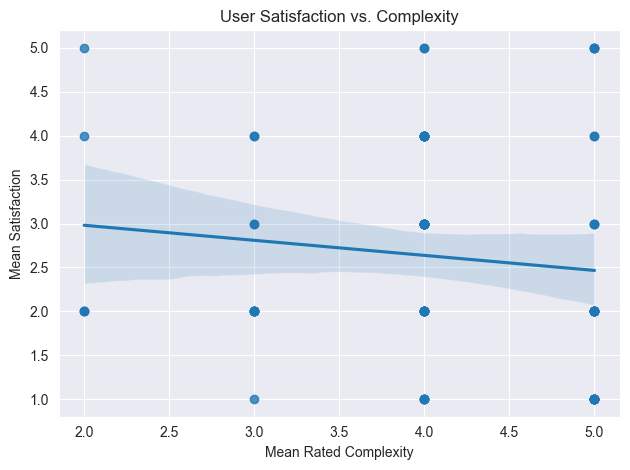

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = users[['satisfaction_code', 'complexity_code']]

sns.regplot(x='satisfaction_code', y='complexity_code', data=corr_df)
plt.xlabel('Mean Rated Complexity')
plt.ylabel('Mean Satisfaction')
plt.title('User Satisfaction vs. Complexity')
plt.tight_layout()
plt.show()

